In [1]:
import sys
from colors import Bcolors as bc

# Numerically solving for eigenstates and eigenvalues of an arbitrary 1D potential

$$V = D_e [1-e^{-\alpha x}]^2$$
- **Equilibrium bond energy**:
    $$D_e=6.091\times10^{-19} \text{ J}$$
- **Equilibrium bond length**:
    $$r_0=9.109\times10^{-11} \text{ m}, \quad x=r-r_0$$
- **Force constant**:
    $$k=1.039\times10^{3} \ \text{J}\text{m}^{-2}, \quad \alpha=\sqrt{ k / 2D_e}$$

# 🔰 Background
## Parameters
- $r$: The internuclear separation between H and F.
- $r_0$: The equilibrium bond length.
- $r-r_0$: The internuclear displacement from nuclear equilbrium.

- $V(r)$: The anharmonic Morse potential.
    - Note: Equilibrium bond length minimizes the potential energy ($D_e := V(r_0) = \min{(V(r))}$).
- $\psi_n(r)$ (**nuclear vibrational wavefunction**): The probablity amplitude for finding the nuclei separated by a distance $r$.
- $E_n$: The vibrational energy level. For the Morse potential, these are:
    $$ \boxed{ E_n = \hbar\omega_e\Big(n + \frac{1}{2} \Big) - \hbar \omega_e x_e\Big(n + \frac{1}{2} \Big)^2 } $$
    - $\omega_e$: The harmonic vibrational frequency at equilibrium. Depends on curvature and reduced mass $\mu$.
    - $x_e$: The anharmonicity constant (dimat equilibrium. Depends on how shallow the well is.

## 1️⃣ Define constants in atomic units

### Define physical constants
📝 Constants are transformed from SI units to atomic units.

In [2]:
# Import necessary libraries
import pandas as pd
from scipy.constants import physical_constants

# Physical constants in SI units
hbar_SI = physical_constants['Planck constant over 2 pi'][0]  # J*s
m_e_SI = physical_constants['electron mass'][0]               # kg
a_0_SI = physical_constants['Bohr radius'][0]                 # m
E_h_SI = physical_constants['Hartree energy'][0]              # J

# Physical constants in atomic units
hbar_AU = 1             # Reduced Planck constant
m_e_AU = 1              # electron mass
a_0_AU = 1              # Bohr radius
E_h_AU = 1              # Hartree energy

# Create a dictionary with the physical constants
physical_constants_data = {
    'Constant': [
        r'hbar',
        r'm_e (electron mass)',
        r'a_0',
        r'E_h'
    ],
    'Value in SI Units': [hbar_SI, m_e_SI, a_0_SI, E_h_SI],
    'SI Units': ['J·s', 'kg', 'm', 'J'], 
    'Value in Atomic Units': [hbar_AU, m_e_AU, a_0_AU, E_h_AU],
    'AU Units': ['reduced Planck constant', 'electron mass', 'Bohr radius', 'Hartree energy']
}

# Create a DataFrame
df = pd.DataFrame(physical_constants_data)
df

,Constant,Value in SI Units,SI Units,Value in Atomic Units,AU Units
0,hbar,1.054572e-34,J·s,1,reduced Planck constant
1,m_e (electron mass),9.109384e-31,kg,1,electron mass
2,a_0,5.291772e-11,m,1,Bohr radius
3,E_h,4.359745e-18,J,1,Hartree energy


## ⚛️ Calculate $\alpha$ using the given $k$ and $D_e$

In [3]:
import numpy as np

# Given values in SI units
k_SI = 1.039e3  # J/m^2
D_e_SI = 6.091e-19  # J
r_0_SI = 9.109e-11  # m

# Convert D_e and r_0 to atomic units
D_e_AU = D_e_SI / E_h_SI
r_0_AU = r_0_SI / a_0_SI

# Correct conversion of k to atomic units
# k_AU = k_SI * (a_0^2 / E_h) in atomic units
k_AU = k_SI * (a_0_SI ** 2) / E_h_SI

print(f"Equilibrium bond length = {r_0_AU:.5f} Bohr radii")
print(f"Equilibrium bond energy = {D_e_AU:.5f} Hartree")
print(f"Force constant in atomic units = {k_AU:.5f}")


Equilibrium bond length = 1.72135 Bohr radii
Equilibrium bond energy = 0.13971 Hartree
Force constant in atomic units = 0.66735


## 2️⃣ Reduced mass, $\mu$ of H-F molecule

$$\mu = \frac{m_\text{H} m_\text{F}}{m_\text{H} + m_\text{F}}$$

In [4]:
# Atomic mass in atomic mass units
m_H_amu = 1.00784     # atomic mass units (Daltons)
m_F_amu = 18.998403   # atomic mass units (Daltons)

# Reduced mass in atomic mass units
mu_amu = (m_H_amu * m_F_amu) / (m_H_amu + m_F_amu)   # Daltons

# Convert to atomic units
m_e_amu = 5.4858e-4         # electron mass (Daltons)
mu_AU = mu_amu / m_e_amu    # reduced mass (atomic units ✔️)

# Reduced mass in atomic mass units (mu / m_e)
print(f"Reduced mass: {bc.GREEN}{mu_AU:.3e} atomic mass units{bc.ENDC}")

Reduced mass: 1.745e+03 atomic mass units


## 5️⃣ Compute harmonic frequency and $\alpha$

In [5]:
# Compute harmonic frequency in atomic units
omega_AU = np.sqrt(k_AU / mu_AU)

# Compute alpha in atomic units
alpha_AU = np.sqrt(k_AU / (2 * D_e_AU))

print(f"Omega in atomic units = {omega_AU:.5f}")
print(f"Alpha in atomic units = {alpha_AU:.5f}")

Omega in atomic units = 0.01956
Alpha in atomic units = 1.54543


In [6]:
# Spatial range in atomic units (typically a few Bohr radii around equilibrium)
xmin = (-2)/(a_0_AU)  # a_0
xmax = (5)/(a_0_AU)   # a_0

N = 1000  # Increase N for better resolution
x = np.linspace(xmin, xmax, N)      # Displacement from equilibrium position
dx = x[1] - x[0]

# Create a dictionary with the data, using raw strings for LaTeX expressions
physical_constants_data = {
    'Grid point/interval': [
        r'xmin',
        r'xmax',
        r'dx',
    ],
    'Value in AU Units': [xmin, xmax, dx],
    'Atomic Units': ['Bohr radii', 'Bohr radii', 'Bohr radii']
}

# Create a DataFrame
df = pd.DataFrame(physical_constants_data)
df

# Displacement from equilibrium position (already in atomic units)

,Grid point/interval,Value in AU Units,Atomic Units
0,xmin,-2.000000,Bohr radii
1,xmax,5.000000,Bohr radii
2,dx,0.007007,Bohr radii


## 4️⃣ Potential and Hamiltonian Setup

### 💙 Calculate the potential $V(x)$ at each point on the grid

In [7]:
V_ii = D_e_AU * (1 - np.exp(-alpha_AU * x))**2   # V in Hartree units

# Set minimum value
V_floor = 1e-6  # Choose an appropriate floor value
V = np.maximum(V_ii, V_floor)

### 🩷 Set up the kinetic energy operator

In [8]:
# Construct the second derivative operator (kinetic energy term)
T_coeff = (hbar_AU**2) / (2 * mu_AU * dx**2)    # Hartree units

# Finite difference
diagonal = 2 * np.ones(N) * T_coeff
off_diagonal = (-1) * np.ones(N - 1) * T_coeff

# Assemble the kinetic energy matrix
from scipy.sparse import diags

T = diags([off_diagonal, diagonal, off_diagonal], offsets=[-1,0,1])

### 🌀 Construct the Hamiltonian Matrix
Combine the kinetic and potential energy terms

In [9]:
# Potential energy matrix (diagonal matrix)
V_matrix = diags(V, 0, format='csr')

# Hamiltonian matrix
H = T + V_matrix

In [10]:
# Ensure no NaNs or infinities:
import numpy as np

if np.isnan(H.data).any() or np.isinf(H.data).any():
    print("Hamiltonian contains NaNs or Infinities. ❌")
else:
    print("Hamiltonian matrix is valid. ✅")

Hamiltonian matrix is valid. ✅


In [11]:
# Print magnitudes of matrix elements
H_data = np.array(H.data)
max_element = np.max(np.abs(H_data))
non_zero_elements = H_data[H_data != 0]  # This extracts all non-zero elements

min_element = np.min(np.abs(non_zero_elements))
print(f"Max Hamiltonian element: {max_element:.5f} Hartrees")
print(f"Min non-zero Hamiltonian element: {min_element:.5f} Hartrees")

Max Hamiltonian element: 73.26314 Hartrees
Min non-zero Hamiltonian element: 5.83716 Hartrees


## 5️⃣ Solving the Schrodinger Equation

In [12]:
from scipy.sparse.linalg import eigsh

# Number of eigenvalues and eigenvectors to compute
num_eigenvalues = 6

# Compute the lowest eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=num_eigenvalues, which='SA', tol=1e-5, maxiter=10000)

# 'which' parameter:
# 'SA' - compute the smallest algebraic eigenvalues
# 'SM' - may not work properly with sparse matrices and complex potentials

### 📏 Converting Eigenvalues to Physical Units

In [13]:
# Eigenvalues are already in Hartree
E_n = eigenvalues   # Hartree

### 🖲️ Normalizing the Eigenfunctions
**Continuous normalization (physics)**:

**Discrete normalization (finite difference grid):**
$$ \sum_i{ | \psi_n(x) |^2 \Delta x} = 1 $$

**Normalization constant:**
$$N = \sqrt{\sum_i{ | \psi_n(x) |^2 \Delta x} }$$

In [14]:
from numpy.typing import NDArray
from typing import List

psi_n: List[NDArray[np.float64]] = []

for i in range(num_eigenvalues):
    psi: NDArray[np.float64] = eigenvectors[:, i]

    # Normalize eigenfunctions
    norm: float = np.sqrt(np.sum(np.abs(psi)**2) * dx)
    psi = psi / norm

    psi_n.append(psi)

### 🔖 Tabulate the Energy Eigenvalues

In [15]:
import pandas as pd
from tabulate import tabulate

# Format the DataFrame
data = {'n': np.arange(num_eigenvalues, dtype=int), 'E_n (Hartree)': np.round(E_n, 5)}
df = pd.DataFrame(data)

# Print as a pretty table
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))


+-----+---------------+
|  n  | E_n (Hartree) |
+-----+---------------+
| 0.0 |    0.00961    |
| 1.0 |    0.02779    |
| 2.0 |    0.04461    |
| 3.0 |    0.06005    |
| 4.0 |    0.07413    |
| 5.0 |    0.08684    |
+-----+---------------+


In [16]:
from typing import Sequence
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from matplotlib.colors import Colormap

def plot_morse(
    x: NDArray[np.float64],
    V: NDArray[np.float64],
    E_n: NDArray[np.float64],
    psi_n: List[NDArray[np.float64]],
    D_e: float,
    r_0: float,
) -> None:
    """
    Morse potential plot with horizontal energy levels and shifted wavefunctions.

    Parameters
    ----------
    x: NDArray[np.float64]
        1D spatial grid.
    V: NDArray[np.float64]
        Anharmonic Morse potential.
    E_n: NDArray[np.float64]
        Energy eigenvalues of the vibrational states.
    psi_n: List[NDArray[np.float64]]
        Wavefunctions of the vibrational states.
    D_e: float
        Equilibrium bond energy in atomic units.
    r_0: float
        Equilibrium bond length in atomic units.
    """
    plt.figure(figsize=(10, 7))

    # Plot dissociation limit
    v_min = min(V)
    plt.axhline(D_e, color="red", linestyle="--", alpha=0.5, label="Dissociation Limit $D_e$")

    # Plot energy levels and shifted wavefunctions
    dynamic_scaling = 0.005
    cmap = plt.cm.cool(np.linspace(0, 0.9, len(E_n)))

    for n, energy in enumerate(E_n):
        # Draw a straight line for each energy level
        well_mask = V <= energy
        if well_mask.any():# focus on the well
            plt.hlines(energy, x[well_mask].min(), x[well_mask].max(),
                   color=cmap[n], linestyle="--", linewidth=2, alpha=0.5)

        # Plot the wavefunctions shifted by its energy level
        plt.plot(x, (psi_n[n] * dynamic_scaling) + energy,
                 color=cmap[n], alpha=0.9, label=fr"$n = {n}$")

    # Plot potential well
    plt.plot(x, V, color="#007FFF", linewidth=3, label="Morse Potential $V(x)$")

    # Formatting
    plt.title("Morse Potential and Bound States for HF", fontsize=16)
    plt.xlabel("Bond length displacement $x$ ($a_0$)", fontsize=14)
    plt.ylabel("Energy (Hartree)", fontsize=14)

    # Zoom into the dissociation limit
    upper = D_e + 0.01
    lower = v_min - 0.025
    plt.ylim(lower, upper)
    plt.xlim(-1, 2)

    plt.legend(loc='best', ncol=2)
    plt.grid(alpha=0.2)
    plt.show()

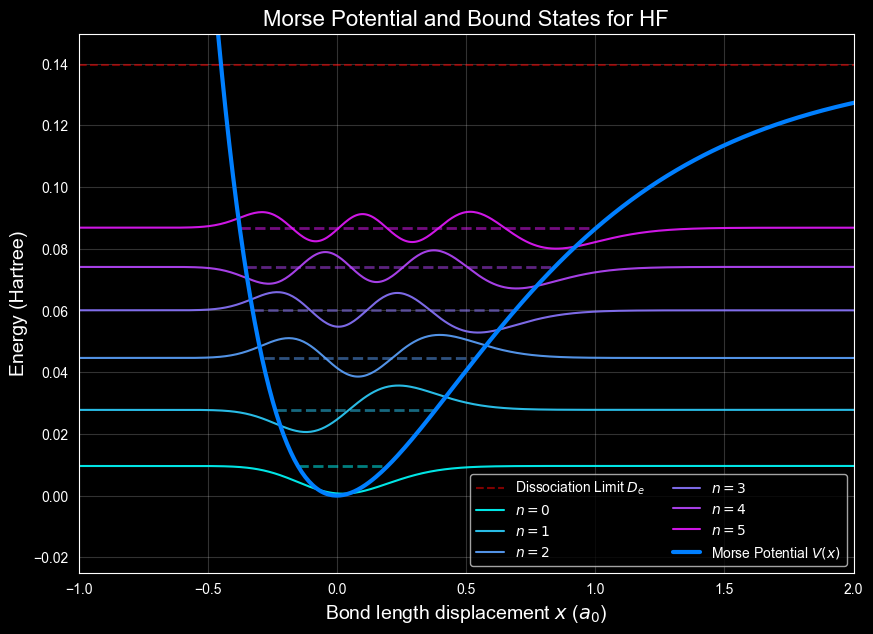

In [17]:
plot_morse(x, V, E_n, psi_n, D_e_AU, r_0_AU)

## ✅ Sanity Checks

In [18]:
def check_bound_states(E_n: np.ndarray, D_e_AU: float) -> None:
    """
    Verifies if all bound states satisfy E < D_e.

    Parameters:
    - E_n (np.ndarray): Array of eigenvalues (energies of the states).
    - D_e_AU (float): Dissociation energy in atomic units.

    Prints whether the condition is satisfied for all states.
    """
    passed = np.all(E_n < D_e_AU)
    if passed:
        print(f"✅ All bound states satisfy E < D_e.")
    else:
        print(f"❌ Some states do not satisfy E < D_e.")
        print(f"Relative Energies (E/D_e): {E_n / D_e_AU}")


def check_normalization(psi_n: list[np.ndarray], dx: float) -> None:
    """
    Checks if all wavefunctions are normalized (integral equals 1).

    Parameters:
    - psi_n (list[np.ndarray]): List of wavefunctions.
    - dx (float): Step size in the spatial grid for integration.

    Prints whether each wavefunction passes normalization.
    """
    all_normalized = True
    for i, psi in enumerate(psi_n):
        norm = np.sum(np.abs(psi) ** 2) * dx
        if not np.isclose(norm, 1.0, atol=1e-6):
            print(f"❌ Wavefunction {i} failed normalization: norm = {norm:.6f}")
            all_normalized = False
        else:
            print(f"✅ Wavefunction {i} is normalized: norm = {norm:.6f}")

    if all_normalized:
        print(f"✅ All wavefunctions are normalized properly.")

In [19]:
# Check that all bound states satisfy E < D_e
print(f"Check: E < D_e = {D_e_AU:.5f} Hartree\n")
check_bound_states(E_n, D_e_AU)

# Check normalization of all wavefunctions
print("\nCheck: Wavefunctions are normalized properly\n")
check_normalization(psi_n, dx)

Check: E < D_e = 0.13971 Hartree

✅ All bound states satisfy E < D_e.

Check: Wavefunctions are normalized properly

✅ Wavefunction 0 is normalized: norm = 1.000000
✅ Wavefunction 1 is normalized: norm = 1.000000
✅ Wavefunction 2 is normalized: norm = 1.000000
✅ Wavefunction 3 is normalized: norm = 1.000000
✅ Wavefunction 4 is normalized: norm = 1.000000
✅ Wavefunction 5 is normalized: norm = 1.000000
✅ All wavefunctions are normalized properly.
